## EDA

In [1]:
from pymongo import MongoClient
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from importlib import reload
import warnings
from gensim.utils import tokenize

from ipywidgets import interact, FloatSlider

In [2]:
# plt.style.available

In [3]:
reload(plt)
warnings.filterwarnings("ignore")

# %matplotlib notebook
%matplotlib inline

# plt.style.use('ggplot')
# plt.style.use('seaborn-pastel')

In [4]:
# Create a client connection to the MongoDb instance running on the local machine
client = MongoClient('localhost:27017')

In [5]:
client.list_database_names()

['Awards', 'admin', 'awards_tmp', 'config', 'local']

In [6]:
# connect to database of interest
db = client.awards_tmp

In [7]:
db.collection_names()

['awards_tmp']

In [8]:
# cursor_tmp is a generator
cursor_tmp = db.awards_tmp.find({}, {'Amount' : 1,
                                     'Agency' : 1,
                                     'title' : 1,
                                     'Branch' : 1,
                                     'Abstract' : 1,
                                     'Awards Year' : 1,
                                     'Phase':1,
                                     '_id': False} )
# need a new cursor (generator) after you used it
df = pd.DataFrame(list(cursor_tmp))

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167412 entries, 0 to 167411
Data columns (total 7 columns):
Abstract       167412 non-null object
Agency         167405 non-null object
Amount         167412 non-null float64
Awards Year    167412 non-null object
Branch         82443 non-null object
Phase          167412 non-null object
title          167412 non-null object
dtypes: float64(1), object(6)
memory usage: 8.9+ MB


In [10]:
df.head()

,Abstract,Agency,Amount,Awards Year,Branch,Phase,title
0,As the Army’s current fielded ground combat an...,Department of Defense,1957570.0,2006,Army,Phase II,Vehicle Enterprise Computational Reliability S...
1,The volume and complexity of information avail...,Department of Defense,1723750.0,2006,Defense Advanced Research Projects Agency,Phase II,Knowledge Flow in Command and Control (C2)
2,"During Phase I, we experimented with several t...",Department of Defense,4056590.0,2006,Navy,Phase II,Modeling the Impact of Technology Transition o...
3,Agiltron proposes to demonstrate a breakthroug...,Department of Homeland Security,150000.0,2006,NaN,Phase I,High Quantum Efficiency Fast Detectors for the...
4,In response to the HSARPA need for the develop...,Department of Homeland Security,150000.0,2006,NaN,Phase I,Metal-Insulator-Semiconductor Gallium Nitride ...


In [11]:
# convert Awards year to datetime object
df['Awards Year'] = pd.to_datetime(df['Awards Year'])

## Add department acronym

In [12]:
agency_name = {'usda' : 'Department of Agriculture',
                'doc' : 'Department of Commerce',
                'dod' : 'Department of Defense',
                'ed' : 'Department of Education',
                'doe' : 'Department of Energy',
                'hhs' : 'Department of Health and Human Services',
                'dhs' : 'Department of Homeland Security',
                'dot' : 'Department of Transportation',
                'epa' : 'Environmental Protection Agency',
                'nasa' : 'National Aeronautics and Space Administration',
                'nsf' : 'National Science Foundation'}

In [13]:
agency_map = {v: k.upper() for k, v in agency_name.items()}

In [14]:
df['agency_abbr'] = df.Agency.map(agency_map)

## Inflation factors

In [15]:
# consumer price index
infl_dir = os.path.join(os.pardir, 'data', 'external', 'SeriesReport-20180624222036_5126de.xlsx')
# first 23 rows are skipped, first column are dates which I used as index
df_infl = pd.read_excel(infl_dir, header=0, skiprows=range(1, 12), parse_dates=True, index_col=0)

In [16]:
# average CPI for each year is in 3rd to last column
# average CPI for 2018 (last row) has not been calculated (not all months are there yet!)
# so I calculated it myself
df_infl.iloc[-1,-3] = df_infl.iloc[-1, :-3].mean()

In [17]:
# only keep annual average CPI
s_infl = df_infl.iloc[:,-3]

In [18]:
# normalized CPI by last available year (2018)
s_infl = s_infl/s_infl[-1]

In [19]:
# add CPI correction factor to my dataframe
df['inflation_factor'] = df['Awards Year'].map(s_infl)

In [20]:
# add corrected dollar amount column
df['amount_corrected'] = df.Amount.divide(df.inflation_factor, fill_value = 0)

#### Replace missing abstract ('N/A') by nan

In [21]:
# mark 'N/A' abstract by nan
df.loc[df.Abstract == 'N/A', 'Abstract'] = np.nan

#### Concatenate Title and abstract

In [22]:
# concatenate abstract and title
df['text'] = df.Abstract.add(df.title, fill_value = '')

### 13 federal agencies:
- Department of Agriculture (USDA), single branch
- Department of Commerce (DoC), NIST, NOAA and Nan branches
- Department of Defense (DoD), 13 branches and Nan branches
- Department of Education (ED), Institute of Education Sciences (IES) and Nan branches
- Department of Energy (DOE), ARPA-E and Nan branches
- Department of Health and Human Services (HHS), National Institutes of Health (NIH) and Nan branches
- Department of Homeland Security (DHS), single branch
- Department of Interior, single branch
- Department of Transportation (DOT), single branch
- Environmental Protection Agency (EPA), single branch
- National and Aeronautics and Space Administration (NASA), single branch
- National Science Foundation (NSF), single branch
- Nuclear Regulatory Commission (NRC), single branch

NIST: National Institute of Standards and Technology <br>
NOAA: National Oceanic and Atmospheric Administration

In [23]:
df.Agency.value_counts(dropna=False)

Department of Defense                            79110
Department of Health and Human Services          38743
National Aeronautics and Space Administration    15499
National Science Foundation                      12043
Department of Energy                             11980
Department of Agriculture                         3294
Environmental Protection Agency                   1795
Department of Commerce                            1438
Department of Education                           1260
Department of Transportation                      1067
Department of Homeland Security                    993
Nuclear Regulatory Commission                      168
Department of Interior                              15
NaN                                                  7
Name: Agency, dtype: int64

In [24]:
df.groupby('Agency').Branch.value_counts(dropna=False)

Agency                                         Branch                                         
Department of Agriculture                      NaN                                                 3294
Department of Commerce                         NaN                                                 1008
                                               National Institute of Standards and Technology       314
                                               National Oceanic and Atmospheric Administration      116
Department of Defense                          Air Force                                          23831
                                               Navy                                               21640
                                               Army                                               15935
                                               Missile Defense Agency                              7950
                                               Defense Advanced Research 

In [25]:
df.Phase.value_counts()

Phase I     118958
Phase II     48454
Name: Phase, dtype: int64

In [26]:
df.describe(include='all')

,Abstract,Agency,Amount,Awards Year,Branch,Phase,title,agency_abbr,inflation_factor,amount_corrected,text
count,139110,167405,1.674120e+05,167412,82443,167412,167412,167222,167412.000000,1.674120e+05,167412
unique,133183,13,NaN,36,18,2,117075,11,NaN,NaN,153892
top,,Department of Defense,NaN,2004-01-01 00:00:00,Air Force,Phase I,N/A,DOD,NaN,NaN,N/A
freq,621,79110,NaN,7630,23831,118958,7123,79110,NaN,NaN,6503
first,NaN,NaN,NaN,1983-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2.878549e+05,NaN,NaN,NaN,NaN,NaN,0.749748,3.708557e+05,NaN
std,NaN,NaN,3.847869e+05,NaN,NaN,NaN,NaN,NaN,0.153961,4.658327e+05,NaN
min,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,0.398864,0.000000e+00,NaN
25%,NaN,NaN,7.000000e+04,NaN,NaN,NaN,NaN,NaN,0.642748,1.089059e+05,NaN


### There are 133,184 Abstracts available over 167,412

### Stats on number of words

In [27]:
# count number of words for each document
df['word_count'] = df['text'].apply(lambda x: len(list(tokenize(x))))

In [28]:
# df.groupby(['Agency', 'Awards Year']).word_count.describe()
df.groupby('Agency').word_count.describe()

,count,mean,std,min,25%,50%,75%,max
Agency,,,,,,,,
Department of Agriculture,3294.0,190.266545,133.096979,2.0,101.0,190.5,245.0,648.0
Department of Commerce,1438.0,139.929764,87.644605,1.0,91.0,159.0,202.0,1331.0
Department of Defense,79110.0,169.486285,95.341158,1.0,118.0,188.0,214.0,1756.0
Department of Education,1260.0,116.318254,96.682646,1.0,13.0,119.0,199.0,474.0
Department of Energy,11980.0,224.225125,125.626053,1.0,166.0,230.0,296.0,1052.0
Department of Health and Human Services,38743.0,249.686937,194.945866,1.0,45.0,220.0,389.0,2386.0
Department of Homeland Security,993.0,178.038268,96.277806,3.0,137.0,200.0,217.0,1050.0
Department of Interior,15.0,144.533333,41.362279,54.0,121.5,150.0,168.5,202.0
Department of Transportation,1067.0,121.786317,87.779889,1.0,11.0,147.0,199.0,543.0


### ECDF on Dollar Amount (All Awards, agency, phase)

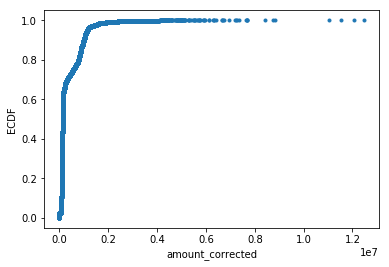

In [29]:
figall , axall = plt.subplots()

pl_x = df.amount_corrected.sort_values().values
pl_y = np.arange(1, len(pl_x)+1) / len(pl_x)
axall.plot(pl_x, pl_y, '.')
axall.set_xlabel('amount_corrected')
axall.set_ylabel('ECDF')

# save figure to file as png
figall.savefig(os.path.join(os.pardir, 'reports', 'figures', 'AmountCorrected_ECDF.png'))

### Dollar Amount distribution per Agency and Phase

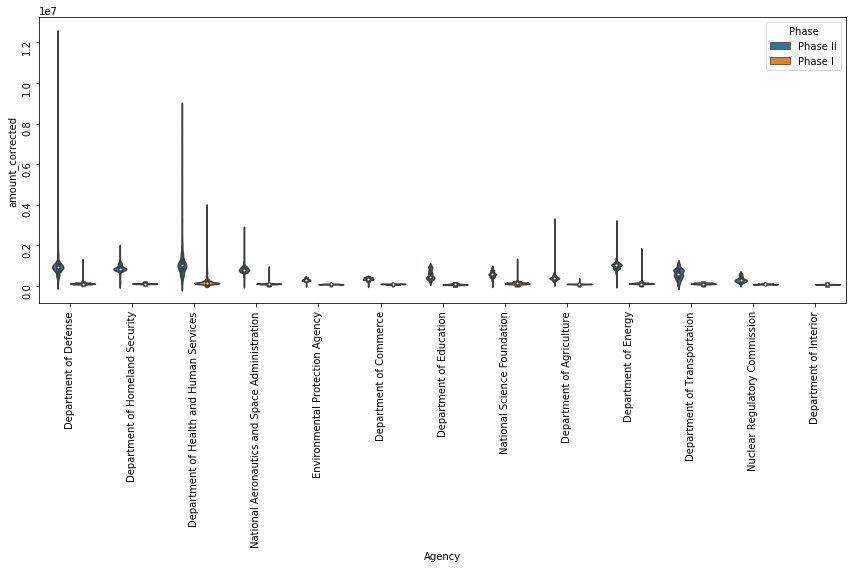

In [30]:
figa , axa = plt.subplots(figsize=(12, 8))
sns.violinplot(x='Agency' , y='amount_corrected', hue ='Phase', data=df, ax = axa, scale='count')
axa.tick_params(rotation=90)
plt.tight_layout()

# save figure to file as png
figa.savefig(os.path.join(os.pardir, 'reports', 'figures', 'AmountCorrected_per_Agency_and_Phase.png'))

### Dollar Amount distribution per Agency and Phase (ECDF)

#### Dollar Amount distribution per Agency

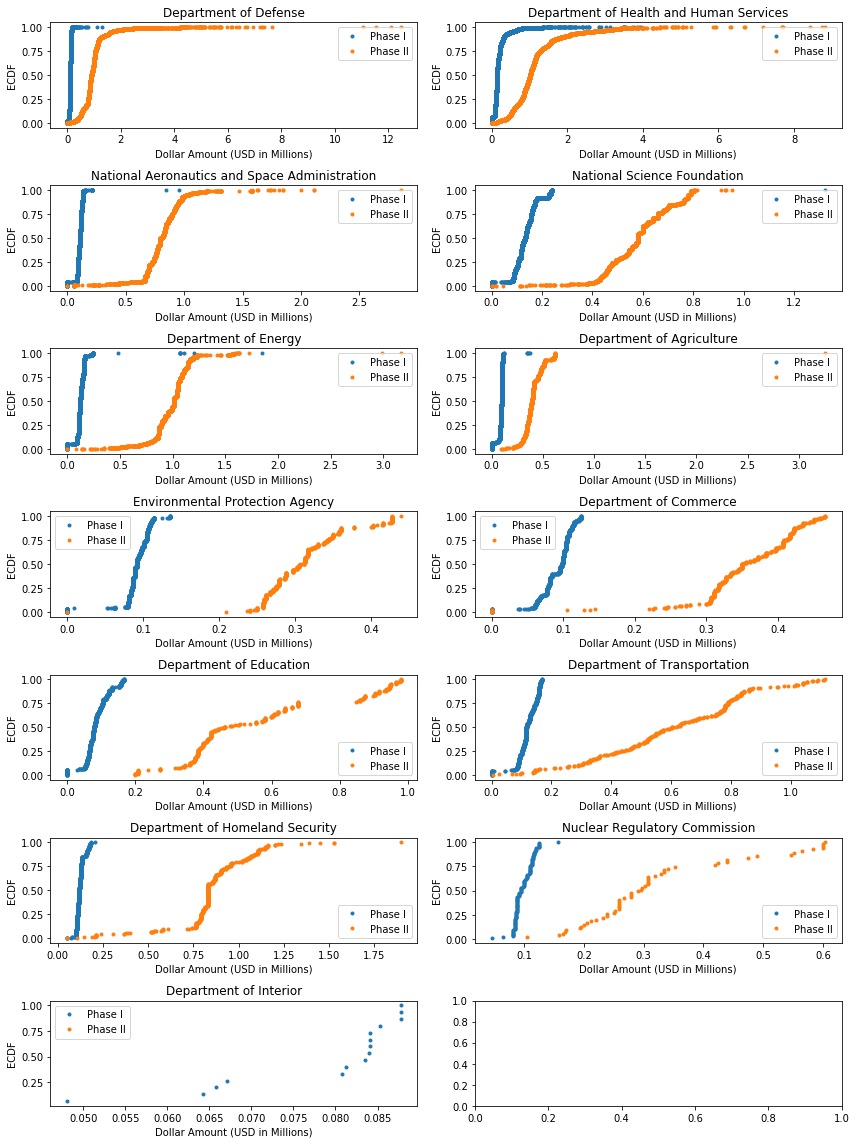

In [31]:
agency_names = df.Agency.value_counts()
num_agency = agency_names.count()

phase_index_list = df.Phase.value_counts().index

# keep 2 columns and compute number of rows needed in subpots
subrows = int(np.ceil(num_agency / 2))
discard_last_ax = bool(num_agency % 2)

# special case when there is only one column specified
# then keep one figure and make it bigger
figsize=(12,16)
if subrows == 1 and discard_last_ax:
    fig , ax = plt.subplots(figsize=figsize)
    ax = [ax]
else:
    fig , ax = plt.subplots(subrows, 2, figsize=figsize)
    ax = ax.flatten()

for i, aname in enumerate(agency_names.index):
    
    for p in phase_index_list:
        
        filt = (df.Agency == aname) & (df.Phase == p)
        pl_x = df.loc[filt, 'amount_corrected'].sort_values()/1e6
        pl_y = np.arange(1, len(pl_x)+1) / len(pl_x)
        ax[i].plot(pl_x, pl_y, linestyle = '', marker='.')
    ax[i].set_xlabel('Dollar Amount (USD in Millions)')
    ax[i].set_ylabel('ECDF')
    ax[i].legend(phase_index_list)
    ax[i].set_title(aname)
plt.tight_layout()

# save figure to file as png
fig.savefig(os.path.join(os.pardir, 'reports', 'figures', 'Amount_per_Agency_ecdf.png'))

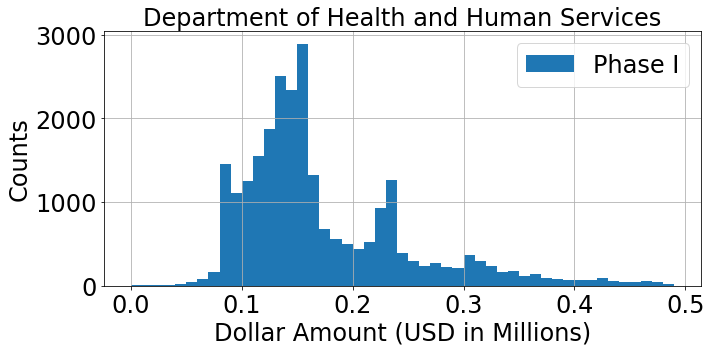

In [32]:
fig , ax = plt.subplots(1, 1, figsize=(10,5))

aname = 'Department of Health and Human Services'

filt = (df.Agency == aname) & (df.Phase == 'Phase I') & (df.amount_corrected > 0)
(df.loc[filt, 'amount_corrected']/1e6).hist(ax=ax, bins = np.arange(0,0.5, 0.01))
ax.set_xlabel('Dollar Amount (USD in Millions)', fontsize = 24)
ax.set_ylabel('Counts', fontsize = 24)
ax.legend(phase_index_list, prop={'size': 24})
ax.set_title(aname, fontsize = 24)
ax.tick_params(axis = 'both', labelsize = 24)
plt.tight_layout()

# save figure to file as png
fig.savefig(os.path.join(os.pardir, 'reports', 'figures', 'Amount_per_Agency_hist_HHS.png'))

In [33]:
# sns.distplot((df.loc[filt, 'amount_corrected']/1e6), bins=np.arange(0,0.5, 0.01), kde=False)

In [34]:
f=FloatSlider(value=1, min=1983, max=2018, step=1, continuous_update=False, description='Alpha')
@interact(alpha=f)
def sample_dirichlet(alpha):
    
    fig, axes = plt.subplots(figsize=(10,8))
#     fig, axes = plt.subplotsv(nrows=3, ncols=3, sharex=True, sharey=True)
#     axes = axes.flatten()
#     plt.setp(axes, ylim=(0, 1))
#     for i, sample in enumerate(samples):
#         axes[i].bar(x=list(range(10)), height=sample, color=sns.color_palette("Set2", 10))
    year = datetime.datetime(int(alpha), 1, 1)
    filt = (df.Agency == 'Department of Health and Human Services') & \
                                            (df.Phase == 'Phase I') & \
                                            (df.amount_corrected > 0) &\
                                            (df['Awards Year'] == year)
    sns.distplot((df.loc[filt, 'amount_corrected']/1e6), bins=np.arange(0,0.5, 0.01), kde=False, ax=axes)
        
#     fig.suptitle('Dirichlet Allocation | 10 Topics, 9 Samples')
    fig.tight_layout()
#     plt.subplots_adjust(top=.95)

interactive(children=(FloatSlider(value=1983.0, continuous_update=False, description='Alpha', max=2018.0, min=…

### Dollar amount mean and std per year

In [35]:
agency_col = 'Agency'

In [36]:
# exclude 2018 as it is incomplete
crit1 = (df.Phase == 'Phase I') & (df.amount_corrected > 0) & (df['Awards Year'] < '2018')

In [37]:
# calculate standard deviation, mean and variance per year and per agency
df_var = df[crit1].groupby([agency_col, 'Awards Year']) \
                .amount_corrected \
                .agg(['std', 'mean', 'var', 'count'])

In [38]:
df_var = df_var.rename(dict(
                zip(['std', 'mean', 'var', 'count'], 
                 ['std_dollar', 'mean_dollar', 'var_dollar', 'count_dollar'])), axis = 1)

In [39]:
# reset multi-index for subsequent groupby
df_var = df_var.reset_index()

#### Dispersion index (aka variance-to-mean ratio)

In [40]:
# compute deviation from mean (variance/mean)
df_var['vmr_dollar'] = df_var.var_dollar.divide(df_var.mean_dollar, fill_value=0)

#### Variance smoothing (moving window average)

In [41]:
# smooth out variance over 4 years (one election term)
df_var['var_smooth'] = df_var.groupby(agency_col).var_dollar.rolling(window=4).mean().values

#### Dispersion index smoothing

In [42]:
df_var['vmr_smooth'] = df_var.groupby(agency_col).vmr_dollar.rolling(window=4).mean().values

#### Normalize Variance, Smoothed variance and Dispersion index by its respective maximum

In [43]:
# normalize variance
df_var['max_var'] = df_var[agency_col].map(df_var.groupby(agency_col).var_dollar.max())
# normalize by maximum variance for each agency
df_var['var_norm'] = df_var.var_dollar.divide(df_var.max_var, fill_value = 0)

In [44]:
# normalize smoothed variance
df_var['max_var_smooth'] = df_var[agency_col].map(df_var.groupby(agency_col)['var_smooth'].max())
# normalize by maximum variance for each agency
df_var['var_smooth_norm'] = df_var['var_smooth'].divide(df_var.max_var_smooth, fill_value = 0)

In [45]:
# normalize dispersion index
df_var['max_vmr'] = df_var[agency_col].map(df_var.groupby(agency_col)['vmr_dollar'].max())
# normalize by maximum variance for each agency
df_var['vmr_dollar_norm'] = df_var['vmr_dollar'].divide(df_var.max_vmr, fill_value = 0)

In [46]:
# normalize dispersion index
df_var['max_vmr_smooth'] = df_var[agency_col].map(df_var.groupby(agency_col)['vmr_smooth'].max())
# normalize by maximum variance for each agency
df_var['vmr_smooth_norm'] = df_var['vmr_smooth'].divide(df_var.max_vmr_smooth, fill_value = 0)

In [47]:
df_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 17 columns):
Agency             376 non-null object
Awards Year        376 non-null datetime64[ns]
std_dollar         376 non-null float64
mean_dollar        376 non-null float64
var_dollar         376 non-null float64
count_dollar       376 non-null int64
vmr_dollar         376 non-null float64
var_smooth         337 non-null float64
vmr_smooth         337 non-null float64
max_var            376 non-null float64
var_norm           376 non-null float64
max_var_smooth     373 non-null float64
var_smooth_norm    373 non-null float64
max_vmr            376 non-null float64
vmr_dollar_norm    376 non-null float64
max_vmr_smooth     373 non-null float64
vmr_smooth_norm    373 non-null float64
dtypes: datetime64[ns](1), float64(14), int64(1), object(1)
memory usage: 50.0+ KB


In [48]:
sns.set_palette(sns.color_palette("Set1", 20))

In [49]:
## seaborn color picker
# sns.choose_colorbrewer_palette('qualitative')

In [68]:
# plt.style.use('classic')
plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')
# plt.style.use('tableau-colorblind10')

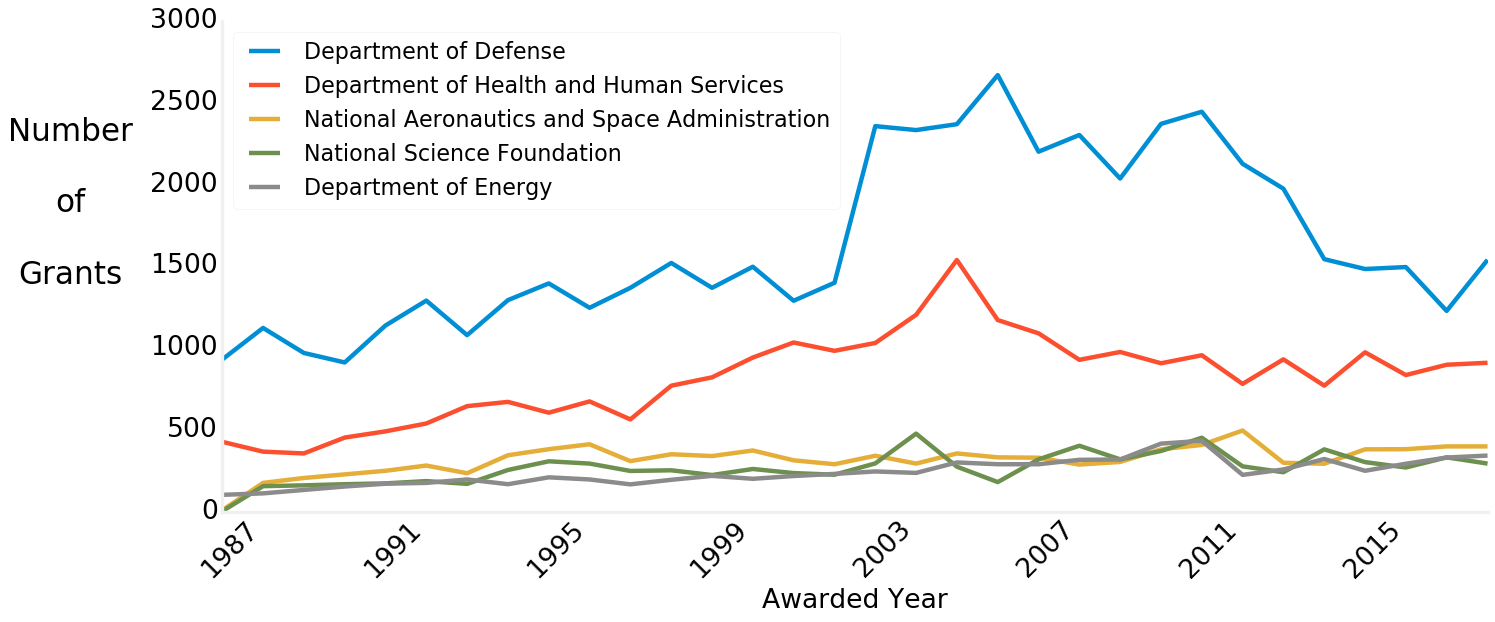

In [120]:
fig, ax = plt.subplots(figsize=(19,8))
fig.set_facecolor('white')

agency_names = df[agency_col].value_counts()[:5]
num_agency = agency_names.count()

for aname in agency_names.index:
    
    filt = (df_var[agency_col] == aname)
    
    df_var[filt].plot(x = 'Awards Year', y = 'count_dollar', ax = ax, x_compat = True )
    
# legend and other aesthetics
ax.legend(agency_names.index, loc = 'upper left', prop={'size': 20}, facecolor='white')
# , bbox_to_anchor=(1.2, 0.5)
ax.set_ylim(0)
ax.set_xlim(pd.Timestamp('1986-01-01'), pd.Timestamp('2017-01-01'))
ax.tick_params(axis = 'both', labelsize = 24)
ax.tick_params(axis = 'x', rotation = 45)
ax.set_xlabel('Awarded Year', fontsize = 24)
ax.set_ylabel('Number\n\nof\n\nGrants', fontsize = 28, rotation=0)
ax.yaxis.set_label_coords(-0.12,0.45)
ax.set_facecolor('white')
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

plt.tight_layout()

# save figure to file as png
fig.savefig(os.path.join(os.pardir, 'reports', 'figures', 'GrantCount_PerAgency_OverTime.png'), transparent=True)

In [78]:
df_var[agency_col].value_counts()

National Science Foundation                      35
Department of Health and Human Services          35
Environmental Protection Agency                  35
Department of Agriculture                        35
Department of Energy                             35
Department of Defense                            35
National Aeronautics and Space Administration    35
Department of Education                          34
Department of Transportation                     34
Department of Commerce                           33
Department of Homeland Security                  14
Nuclear Regulatory Commission                    13
Department of Interior                            3
Name: Agency, dtype: int64

In [79]:
plt.rcParams['axes.prop_cycle'].by_key()['color']

['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']

Department of Defense
Department of Health and Human Services
National Science Foundation


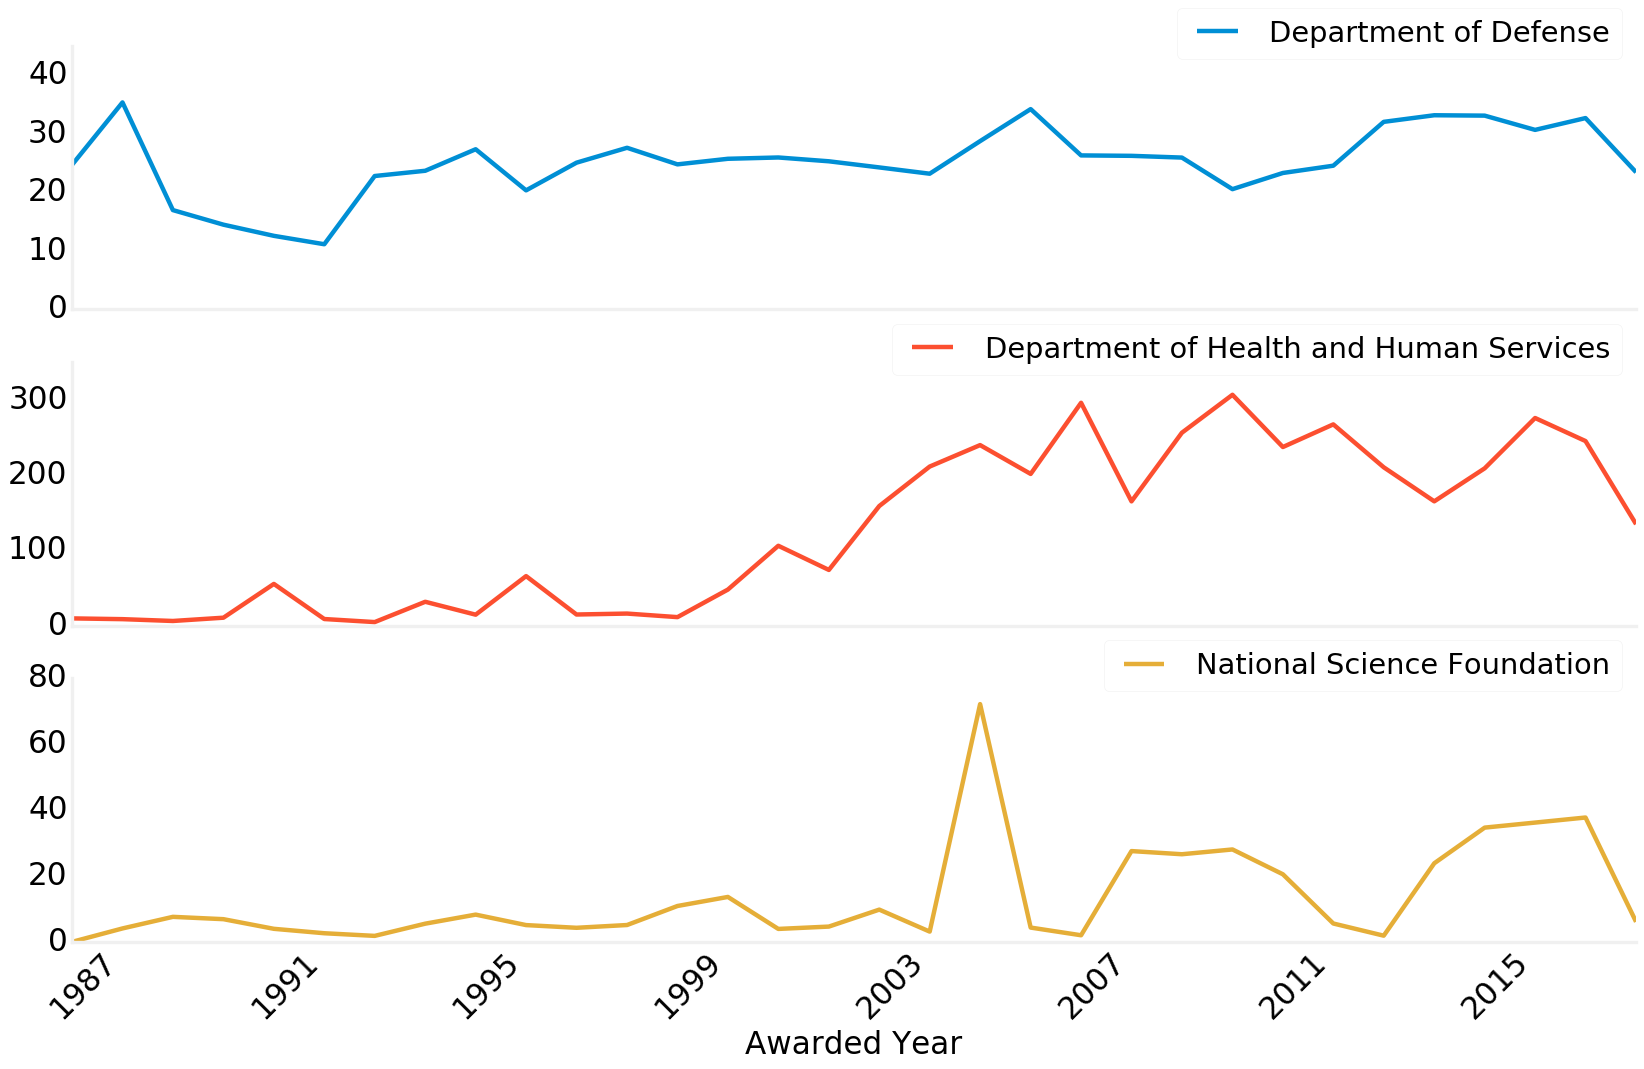

In [149]:
agency_names = df[agency_col].value_counts().iloc[[0,1,3]]
num_agency = agency_names.count()

fig, ax = plt.subplots(num_agency, 1, figsize=(23,16), sharex=True)
fig.set_facecolor('white')
# fig.subplots_adjust(hspace=0.1, left = 0.1, bottom = 0.1)
fig.subplots_adjust( left = 0.1, bottom = 0.1)

# for x in ax:
#     current_pos = x.get_position()
#     print(current_pos)
#     new_pos = [current_pos.x0 + 0.02, current_pos.y0,
#                current_pos.width, current_pos.height]
#     x.set_position(new_pos)
# get current color cycle
colour = plt.rcParams['axes.prop_cycle'].by_key()['color']
cutoff = ['1987', '1999', '2003']

for pi, aname in enumerate(agency_names.index):
    
    filt = (df_var[agency_col] == aname)
    print(aname)
    dftmp = df_var[filt]
    dftmp['std_dollar'] = dftmp['std_dollar']/1000
    dftmp.plot(x = 'Awards Year', y = 'std_dollar',
                      ax = ax[pi], c = colour[pi%len(colour)], x_compat = True,
                     label = aname)
    
#     ax[pi].axvline(cutoff[pi], alpha=0.3, color='k', linestyle='--')
    ax[pi].set_ylim(0)
# legend and other aesthetics
#     ax[pi].legend( loc = 'upper left', prop={'size': 20}, bbox_to_anchor=(0, 1.2))
    ax[pi].legend( loc = 'upper right', prop={'size': 26}, facecolor='white', bbox_to_anchor=(1, 1.2))
#     ax[pi].set_ylim(-600)
    ax[pi].set_xlim(pd.Timestamp('1986-01-01'), pd.Timestamp('2017-01-01'))
    ax[pi].tick_params(axis = 'both', labelsize = 28)
    ax[pi].tick_params(axis = 'x', rotation = 45)
    ax[pi].set_xlabel('', fontsize = 24)
    ax[pi].set_facecolor('white')
    ax[pi].grid(False)
    ax[pi].spines['right'].set_visible(False)
    ax[pi].spines['top'].set_visible(False)
    ax[pi].xaxis.set_ticks_position('bottom')
    yticks = ax[pi].yaxis.get_major_ticks()
#     print(yticks)
#     yticks[-1].label1.set_visible(False)

    for i,t in enumerate(yticks): 
#         if (i == 1) or (i == len(yticks)-2):
        if (i%2) == 0 or i == 0:
            t.label1.set_visible(True)
        else:
            t.label1.set_visible(False)
            
            
#     yticks[0].label1.set_visible(True)
#     ax[pi].axes.yaxis.set_ticklabels([])
#     if pi < num_agency - 1:
#         ax[pi].set_xticklabels('', fontsize = 24)
#     ax[pi].set_xlabel('Awarded Year', fontsize = 24)
# ax.set_ylabel('Dollar Amount Dispersion Index', fontsize = 24)
# ax.set_yscale('symlog')
plt.xlabel('Awarded Year', fontsize = 28)

# plt.ylabel('Dispersion Index (Dollar Amount USD)')
# fig.text(0.00, 0.5, 'Dispersion Index of Dollar Amount',
# fig.text(0.00, 0.5, 'Standard Deviation (USD)',
#          va='center', fontsize = 40)
# fig.text(0.5, 0.00, 'Awarded Year', va='center', fontsize = 24)
# plt.tight_layout()

# save figure to file as png
fig.savefig(os.path.join(os.pardir, 'reports', 'figures', 'DispersionIndex_PerAgency_OverTime.png'),
           transparent=True)

### Dollar amount distibution over time (one agency at a time)

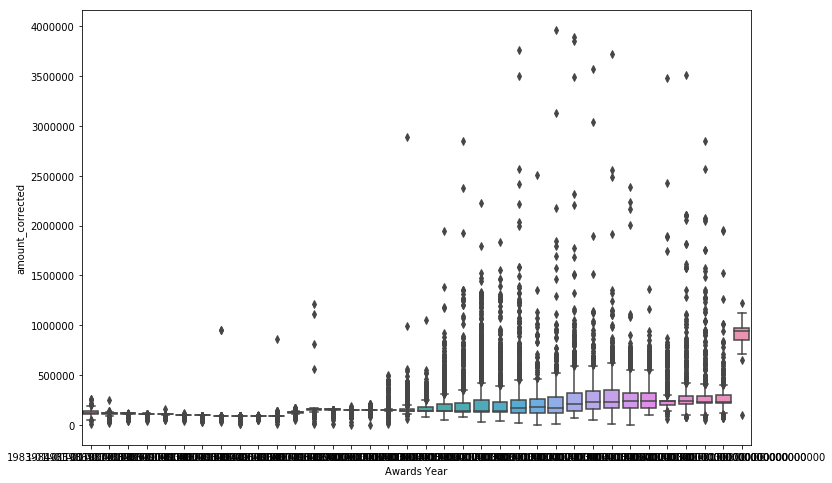

In [103]:
fig, ax = plt.subplots(figsize=(12,8))

aname = 'Department of Health and Human Services'
filt = (df.Agency == aname) & (df.Phase == 'Phase I') & (df.amount_corrected > 0)
# (df.loc[filt, 'amount_corrected']/1e6)
sns.boxplot(x = 'Awards Year', y = 'amount_corrected', data = df[filt], ax=ax )

### Wave plot (does not show much information)

In [25]:
# # define color palette
# num_years = df['Awards Year'].value_counts().count()
# pal = sns.cubehelix_palette(num_years, rot = -.25, light = .7)

In [39]:
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight='bold', color = color,
#            ha='left', va='center', transform=ax.transAxes)

In [55]:
# g = sns.FacetGrid(df, row = 'Awards Year', hue = 'Awards Year', aspect = 15, size = .5, palette = pal)
# # g.map(sns.kdeplot, 'amount_corrected', clip_on=False, shade=True, alpha=.1, lw=1.5, bw=.2)
# # g.map(sns.kdeplot, 'amount_corrected', clip_on=False, lw=1.5, bw=.2)
# g.map(sns.distplot, 'amount_corrected', bins=np.arange(0,4, 0.01), kde=False)
# g.map(sns.distplot, 'amount_corrected')
# g.map(plt.axhline, y=0, clip_on=False, lw=2)

# g.map(label, 'amount_corrected')
# g.fig.subplots_adjust(hspace=-0.25)

# g.set_titles('')
# g.set(yticks=[])
# g.despine(bottom=True, left=True)

#### Dollar Amount distribution per Phase (ECDF)

<IPython.core.display.Javascript object>


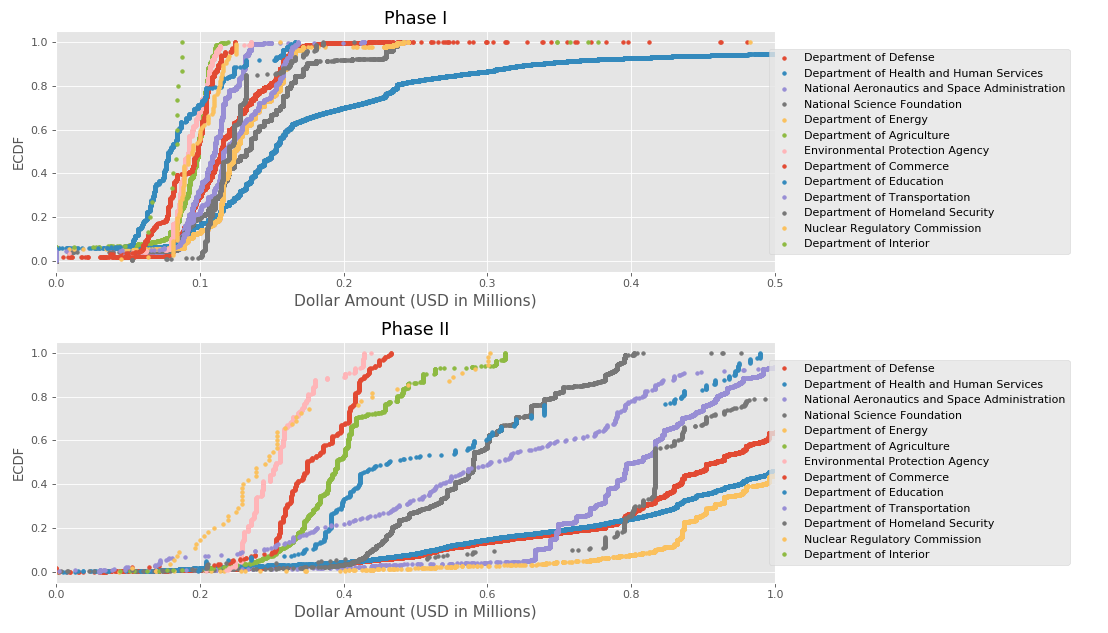

In [49]:
phase_names = df.Phase.value_counts()
agency_names = df.Agency.value_counts()

# special case when there is only one column specified
# then keep one figure and make it bigger
figdollar , axdollar = plt.subplots(2, 1, figsize=(14,8))
axdollar = axdollar.flatten()

for j, p in enumerate(phase_names.index):
    
    for aname in agency_names.index:
    
        filt = (df.Agency == aname) & (df.Phase == p)
        pl_x = df.loc[filt, 'amount_corrected'].sort_values()/1e6
        pl_y = np.arange(1, len(pl_x)+1) / len(pl_x)
        axdollar[j].plot(pl_x, pl_y, linestyle = '', marker='.')
    axdollar[j].set_xlabel('Dollar Amount (USD in Millions)', fontsize = 14)
    axdollar[j].set_ylabel('ECDF')
    axdollar[j].legend(agency_names.index, loc = 'center', bbox_to_anchor=(1.2, 0.5))
    axdollar[j].set_title(p, fontsize = 16)
plt.tight_layout()

axdollar[0].set_xlim([0, 0.5])
axdollar[1].set_xlim([0, 1])

# save figure to file as png
figdollar.savefig(os.path.join(os.pardir, 'reports', 'figures', 'Amount_per_Phase_ecdf.png'))

### Dollar Amount distribution per Agency and Phase (Distribution)

In [122]:
# some amount are 0 dollars
df[df.Amount == 0].shape

(4244, 9)

In [123]:
df_amount = df[~(df.Amount == 0)]

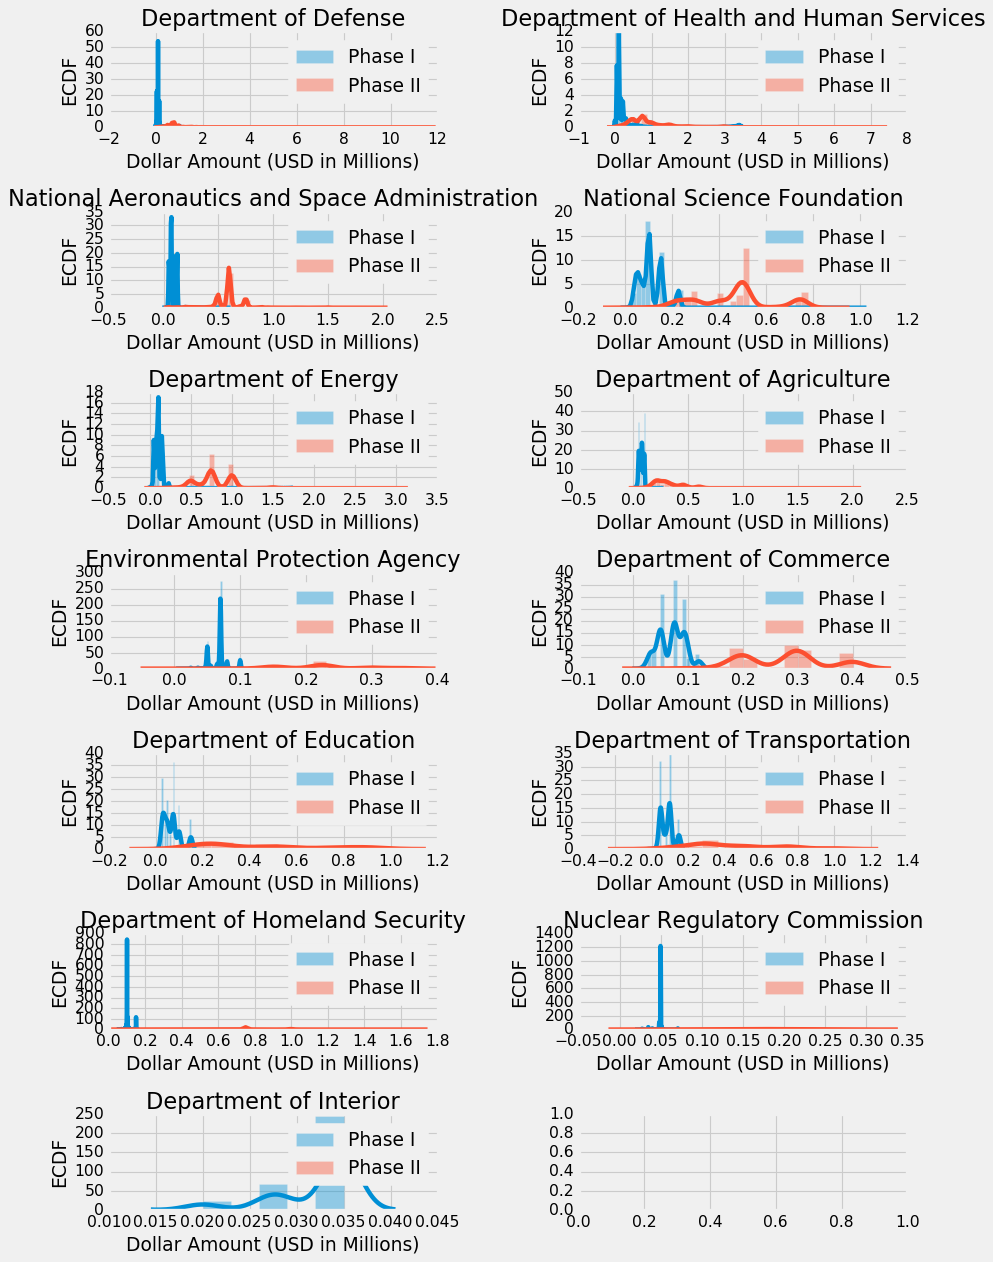

In [124]:
agency_names = df_amount.Agency.value_counts()
num_agency = agency_names.count()

phase_index_list = df_amount.Phase.value_counts().index

# keep 2 columns and compute number of rows needed in subpots
subrows = int(np.ceil(num_agency / 2))
discard_last_ax = bool(num_agency % 2)

# special case when there is only one column specified
# then keep one figure and make it bigger
figsize=(12,16)
if subrows == 1 and discard_last_ax:
    figg , axx = plt.subplots(figsize=figsize)
    axx = [axx]
else:
    figg , axx = plt.subplots(subrows, 2, figsize=figsize)
    axx = axx.flatten()

for i, aname in enumerate(agency_names.index):
    
    for p in phase_index_list:
        
        filt = (df_amount.Agency == aname) & (df_amount.Phase == p)
        pl_x = df_amount.loc[filt, 'Amount'].sort_values()/1e6
        sns.distplot(pl_x, ax=axx[i])
        
    axx[i].set_xlabel('Dollar Amount (USD in Millions)')
    axx[i].set_ylabel('ECDF')
    axx[i].legend(phase_index_list)
    axx[i].set_title(aname)
plt.tight_layout()

# save figure to file as png
figg.savefig(os.path.join(os.pardir, 'reports', 'figures', 'Amount_per_Agency_and_Phase_distrib.png'))

### Number of awards per Agency and per Phase

In [ ]:
figb , axb = plt.subplots(figsize=(12, 8))
sns.countplot(x='Agency' , hue ='Phase', data=df, ax = axb, )
axb.tick_params(rotation=90)
plt.tight_layout()

### Number of awards per Agency and per Phase (NORMALIZED)

In [59]:
plt.style.use('ggplot')
plt.style.use('tableau-colorblind10')

<IPython.core.display.Javascript object>


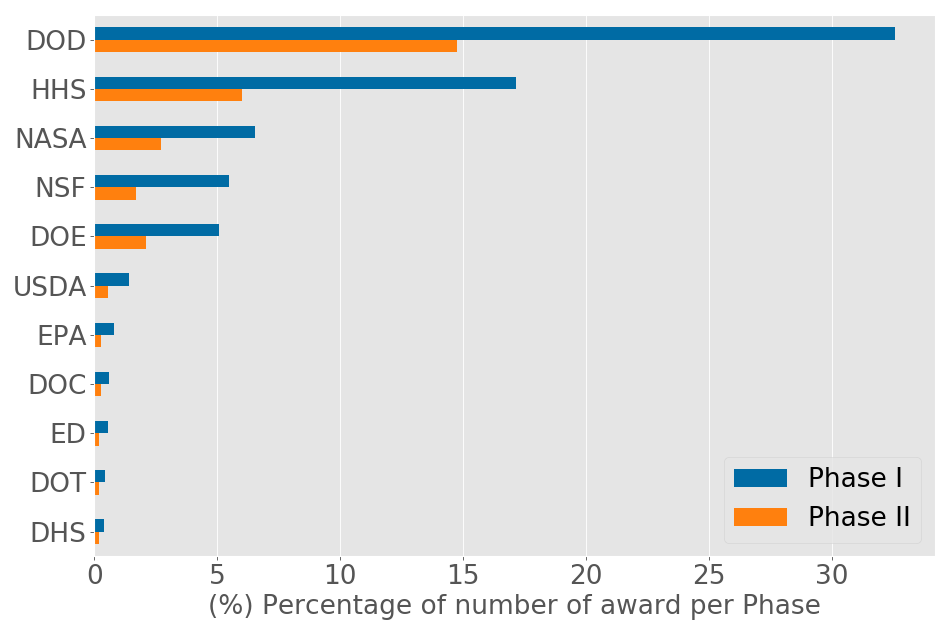

In [61]:
figcnt , axcnt = plt.subplots(figsize=(12, 8))

# pivot on relevant columns, values can be anything as we are just counting here
df_plan = df.pivot_table(index = 'agency_abbr', \
                         columns = 'Phase',\
                         values = 'Amount',\
                         aggfunc = 'count',\
                         fill_value = 0)

# normalize each column by counts of respective column
# df_plan = df_plan.divide(df_plan.sum()) * 100
# normalize by total number of awards
df_plan = df_plan/df_plan.sum().sum() * 100
df_plan = df_plan.sort_values(['Phase I', 'Phase II'], ascending=False)
df_plan = df_plan.head(5)

# make a bar plot for each auto renew state
df_plan.plot(kind = 'barh', ax = axcnt)
# change tick orientation and add labels
axcnt.tick_params(axis = 'both', labelsize = 24)
axcnt.set_xlabel('(%) Percentage of number of award per Phase', fontsize = 24)
axcnt.set_ylabel('')
axcnt.invert_yaxis()
axcnt.yaxis.grid()
plt.legend(prop={'size': 24}, loc = 'lower right')
plt.tight_layout()

# save figure to file as png
figcnt.savefig(os.path.join(os.pardir, 'reports', 'figures', 'Count_per_Agency_and_Phase.png'))
# figcnt.savefig(os.path.join(os.pardir, 'reports', 'figures', 'Count_per_Agency_and_Phase_full.png'))